This notebook is for mapping out the Dovetrek checkpoints.

###Contents:
* [Imports](#Imports)
* [Start SparkSession](#Start-SparkSession)
* [Set Parameters](#set-params)
* [Get Secrets](#get-secrets)
* [Fetch Checkpoint Information](#fetch-cp-info)
* [Convert BNG to NGR](#bgn-to-ngr)
* [Convert NGR to Latitude/Logitude](#ngr-to-latlong)
* [Latitude/Longitude Bounding Box](#latlong-bbox)
* [NGR Bounding Box](#ngr-bbox)
* [Bing Maps plot Checkpoints](#bing-cp-map)
* [Azure Maps plot Checkpoints](#)
* [Ordnance Survey Map Plotting Calculations](#os-calcs)
  * [Get Checkpoint Pixel coordinates](#cp-pixel-coords)
  * [Add tilename and pixel coordinates to Openings_DF](#openings_df-coords)
  * [Fetch tiles and plot checkpoints](#get-tiles)
  * [Store canvas in memory](#canvas-to-memory)
  * [Save canvas back to filestore](#canvas-to-filestore)


In [1]:
pip install Pillow

### Imports

In [2]:
from pyspark.sql.functions import udf, col, expr, first, max, min
from pyspark.sql import functions as F, DataFrame, Window, SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, FloatType, ArrayType, TimestampType
from datetime import datetime, time, timedelta
import requests
import time
import builtins
import json
import os
import ipywidgets
import base64
import getpass
import math
from IPython.display import Image, clear_output
import itertools
from functools import reduce
import numpy as np
from io import BytesIO, StringIO
from PIL import Image as PILImage, ImageDraw, ImageFont

### Start SparkSession

In [3]:
try:
    SparkSession.active()
except:
    spark = SparkSession.builder \
        .appName("BinderPySpark") \
        .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
        .getOrCreate()
else:
    SparkSession.active()
finally:
    # Test if Spark is working
    df = spark.createDataFrame([(1, "Alice"), (2, "Bob")], ["id", "name"])
    df.show()
    df.unpersist()

+---+-----+
| id| name|
+---+-----+
|  1|Alice|
|  2|  Bob|
+---+-----+



### Get available competition years

In [4]:
url = f"https://api.github.com/repos/liamj-f/Dovetrek/contents/CheckpointData"
params = {"ref": "main"}
response = requests.get(url, params=params)
response.json()
# Extract the 'name' field from each item in the JSON response
Year_List = [item['name'] for item in response.json() if 'name' in item]

# Extract the year using string slicing
Year_List = [filename.split('_')[1].split('.')[0] for filename in Year_List]

### Set Parameters

In [5]:
Map_Style_List = ["Outdoor_27700", "Leisure_27700", "Road_27700", "Light_27700"]

Competition_Year_Picker = ipywidgets.Dropdown(options=Year_List, value ='2025', description = 'Pick a competition year:')
Map_Style_Picker = ipywidgets.Dropdown(options=Map_Style_List, value ="Outdoor_27700", description = 'Pick an Ordnance Survey Map Style:')
# per https://docs.os.uk/os-apis/accessing-os-apis/os-maps-apilayers-and-styles
Zoom_Level_Picker = ipywidgets.IntSlider(value = 7
                                         , min = 0
                                         , max= 9
                                         , description = 'Pick a Zoom level'
                                         , readout = True
                                        , step = 1)

display(Competition_Year_Picker, Map_Style_Picker, Zoom_Level_Picker)

# Create a button and output display area
run_button = ipywidgets.Button(description="Confirm Selection")
output = ipywidgets.Output()

def on_run_button_clicked(b):
    with output:
        clear_output()
        global Competition_Year, MapStyle, zoom_level
        Competition_Year = Competition_Year_Picker.value
        MapStyle = Map_Style_Picker.value
        zoom_level = Zoom_Level_Picker.value
        print(f"Competition year: {Competition_Year}\nMap Style: {MapStyle}\nZoom Level: {zoom_level}")

run_button.on_click(on_run_button_clicked)
display(run_button, output)
###################

print("Make sure all of the parameters are set correctly and confirm selection before entering your GitHub Secrets repository Personal Access Token below")
GitHubPAT = getpass.getpass("Token:")

Dropdown(description='Pick a competition year:', index=4, options=('2017', '2018', '2019', '2024', '2025'), va…

Dropdown(description='Pick an Ordnance Survey Map Style:', options=('Outdoor_27700', 'Leisure_27700', 'Road_27…

IntSlider(value=7, description='Pick a Zoom level', max=9)

Button(description='Confirm Selection', style=ButtonStyle())

Output()

Make sure all of the parameters are set correctly and confirm selection before entering your GitHub Secrets repository Personal Access Token below
Token:··········


### Check parameters correctly set

In [8]:
time.sleep(3)
print(f"Competition year: {Competition_Year}\nMap Style: {MapStyle}\nZoom Level: {zoom_level}")

Competition year: 2025
Map Style: Outdoor_27700
Zoom Level: 7


In [10]:
BingMapsAPIKey = ""

### Get Secrets

In [9]:
# 🔹 GitHub API URL to get the file
url = f"https://api.github.com/repos/liamj-f/Secrets/contents/Dovetrek_Secrets.json"

# 🔹 GitHub API headers
headers = {"Authorization": f"token {GitHubPAT}"}

# 🔹 Fetch the secrets file
response = requests.get(url, headers=headers)

if response.status_code == 200:
    # Decode Base64 content
    content = response.json()["content"]
    decoded_content = base64.b64decode(content).decode("utf-8")

    # Load JSON into a dictionary
    secrets = json.loads(decoded_content)

    # 🔹 Assign values to variables
    BingMapsAPIKey = secrets.get("BingMApsAPIKey", "")
    AzureMapsAPIKey = secrets.get("AzureMapsAPIKey", "")
    OrdnanceSurveyAPIKey = secrets.get("OrdnanceSurveyAPIKey", "")
    OpenRouteServiceAPIKey = secrets.get("OpenRouteServiceAPIKey", "")
    GoogleMapsAPIKey = secrets.get("GoogleMapsAPIKey", "")
    DovetrekRepoPAT = secrets.get("DovetrekRepoPAT", "")

    print("✅ Secrets loaded successfully!")

else:
    print(f"❌ Error: {response.status_code} - {response.text}")


✅ Secrets loaded successfully!


### Fetch Checkpoint information

In [ ]:
# GitHub API URL for file content
url = f"https://api.github.com/repos/liamj-f/Dovetrek/contents/CheckpointData/Openings_{Competition_Year}.csv"

# Fetch file content
response = requests.get(url)

content = response.json()["content"]
decoded_content = base64.b64decode(content).decode("utf-8")
csv_lines = decoded_content.split("\n")
# Create an RDD from the list
rdd = spark.sparkContext.parallelize(csv_lines)
# Convert RDD to DataFrame
openings_df = spark.read.csv(rdd, header=True, inferSchema=True)

### Convert BNG to NGR
The actual grid square identifiers are missing from the datasets because Dovetrek always takes place in the same area, so conversion from letter to number not necessary.

In [ ]:
openings_df = openings_df.withColumn("NGR_Easting", F.concat(F.lit("4"), F.substring(openings_df.BNG, 1, 3), F.lit("00")).cast("int")) \
                    .withColumn("NGR_Northing", F.concat(F.lit("3"), F.substring(openings_df.BNG, 5, 3), F.lit("00")).cast("int"))
display(openings_df)

DataFrame[CP: string, BNG: string, 1000: int, 1030: int, 1100: int, 1130: int, 1200: int, 1230: int, 1300: int, 1330: int, 1400: int, 1430: int, 1500: int, 1530: int, 1600: int, 1630: int, 1700
: double, NGR_Easting: int, NGR_Northing: int]

### Convert NGR to Lat/Long

In [ ]:
LatLong_Df = spark.createDataFrame(
    [(1, 1.0, 1.0)],
    schema='CP string, Latitude float, Longitude float'
)
LatLong_Df = LatLong_Df.filter('1!=1')

# Convert DataFrame to a list
gridrefs_list = openings_df.select(
    openings_df.CP,
    openings_df.NGR_Easting,
    openings_df.NGR_Northing
).collect()

# Iterate over the list
for row in gridrefs_list:
    # Perform desired operations with the column values
    resp = requests.get(
        "http://webapps.bgs.ac.uk/data/webservices/CoordConvert_LL_BNG.cfc?method=BNGtoLatLng&easting="
        + str(row.NGR_Easting)
        + "&northing="
        + str(row.NGR_Northing)
    )

    # Parse the JSON response
    json_resp = json.loads(resp.text)

    # Check if 'LATITUDE' and 'LONGITUDE' keys exist in the response
    if 'LATITUDE' in json_resp and 'LONGITUDE' in json_resp:
        # Extract latitude and longitude values
        latitude = json_resp['LATITUDE']
        longitude = json_resp['LONGITUDE']
        cp = row["CP"]

        df = spark.createDataFrame(
            [(cp, latitude, longitude)],
            'CP string, Latitude float, Longitude float'
        )
        LatLong_Df = LatLong_Df.union(df)

openings_df = openings_df.join(LatLong_Df, openings_df.CP == LatLong_Df.CP).drop(LatLong_Df.CP)

LatLong_Df.unpersist()
# Show DataFrame
display(openings_df)

DataFrame[CP: string, BNG: string, 1000: int, 1030: int, 1100: int, 1130: int, 1200: int, 1230: int, 1300: int, 1330: int, 1400: int, 1430: int, 1500: int, 1530: int, 1600: int, 1630: int, 1700
: double, NGR_Easting: int, NGR_Northing: int, Latitude: float, Longitude: float]

### LatLong Bounding Box

In [ ]:
east, west, north, south = openings_df.agg(
    max(col("Longitude")).alias("East"),
    min(col("Longitude")).alias("West"),
    max(col("Latitude")).alias("North"),
    min(col("Latitude")).alias("South"),
).first()

# Approximate 200m offset values
lat_offset = 200 / 111320  # ~0.001796 degrees
lon_offset = 200 / 67690   # ~0.002954 degrees (at ~53° latitude)

# Adjust bounding box
north += lat_offset
south -= lat_offset
east += lon_offset
west -= lon_offset

# Create new bounding box
LLBbox = f"{west}, {south}, {east}, {north}"

print(LLBbox)


-1.8166521034946574, 53.34359369747423, -1.6875702895412312, 53.386806387974985


### NGR Bounding Box

In [ ]:
# Aggregate and pad Easting/Northing correctly
east, west, north, south = openings_df.agg(
    max(col("NGR_Easting")).cast("int").alias("East"),
    min(col("NGR_Easting")).cast("int").alias("West"),
    max(col("NGR_Northing")).cast("int").alias("North"),
    min(col("NGR_Northing")).cast("int").alias("South"),
).first()

# Collect bounding box values

north, east, south, west

(387600, 420700, 383200, 412500)

### Bing Maps plot Checkpoints

In [14]:
if BingMapsAPIKey != "":

  url = "https://dev.virtualearth.net/REST/v1/Imagery/Map/Road"

  url_params = {
      "mapLayer": "OrdnanceSurvey",
      "format": "png",
      "mapMetadata": 0,
      "declutterPins": 0,
      "mapSize": "2000, 1600",
  #   "mapArea": f"{north_east},{south_west}",
      "key": BingMapsAPIKey
  }

  req_body = "&".join([f"pp={row['Latitude']},{row['Longitude']};35;{row['CP'][:3]}" for row in openings_df.collect()])
  req_body_bytes = req_body.encode('utf-8')

  req_headers = {
      "content-type": "text/plain",
      "charset": "utf-8",
      "Content-Length":str(len(req_body_bytes))
  }

  resp = requests.post(url, headers=req_headers, params=url_params, data=req_body)

  display(Image(resp.content))
  resp.status_code
else:
  print('No Bing Map API Key, unable to query API')


No Bing Map API Key, unable to query API


### Azure Maps Plot Checkpoints

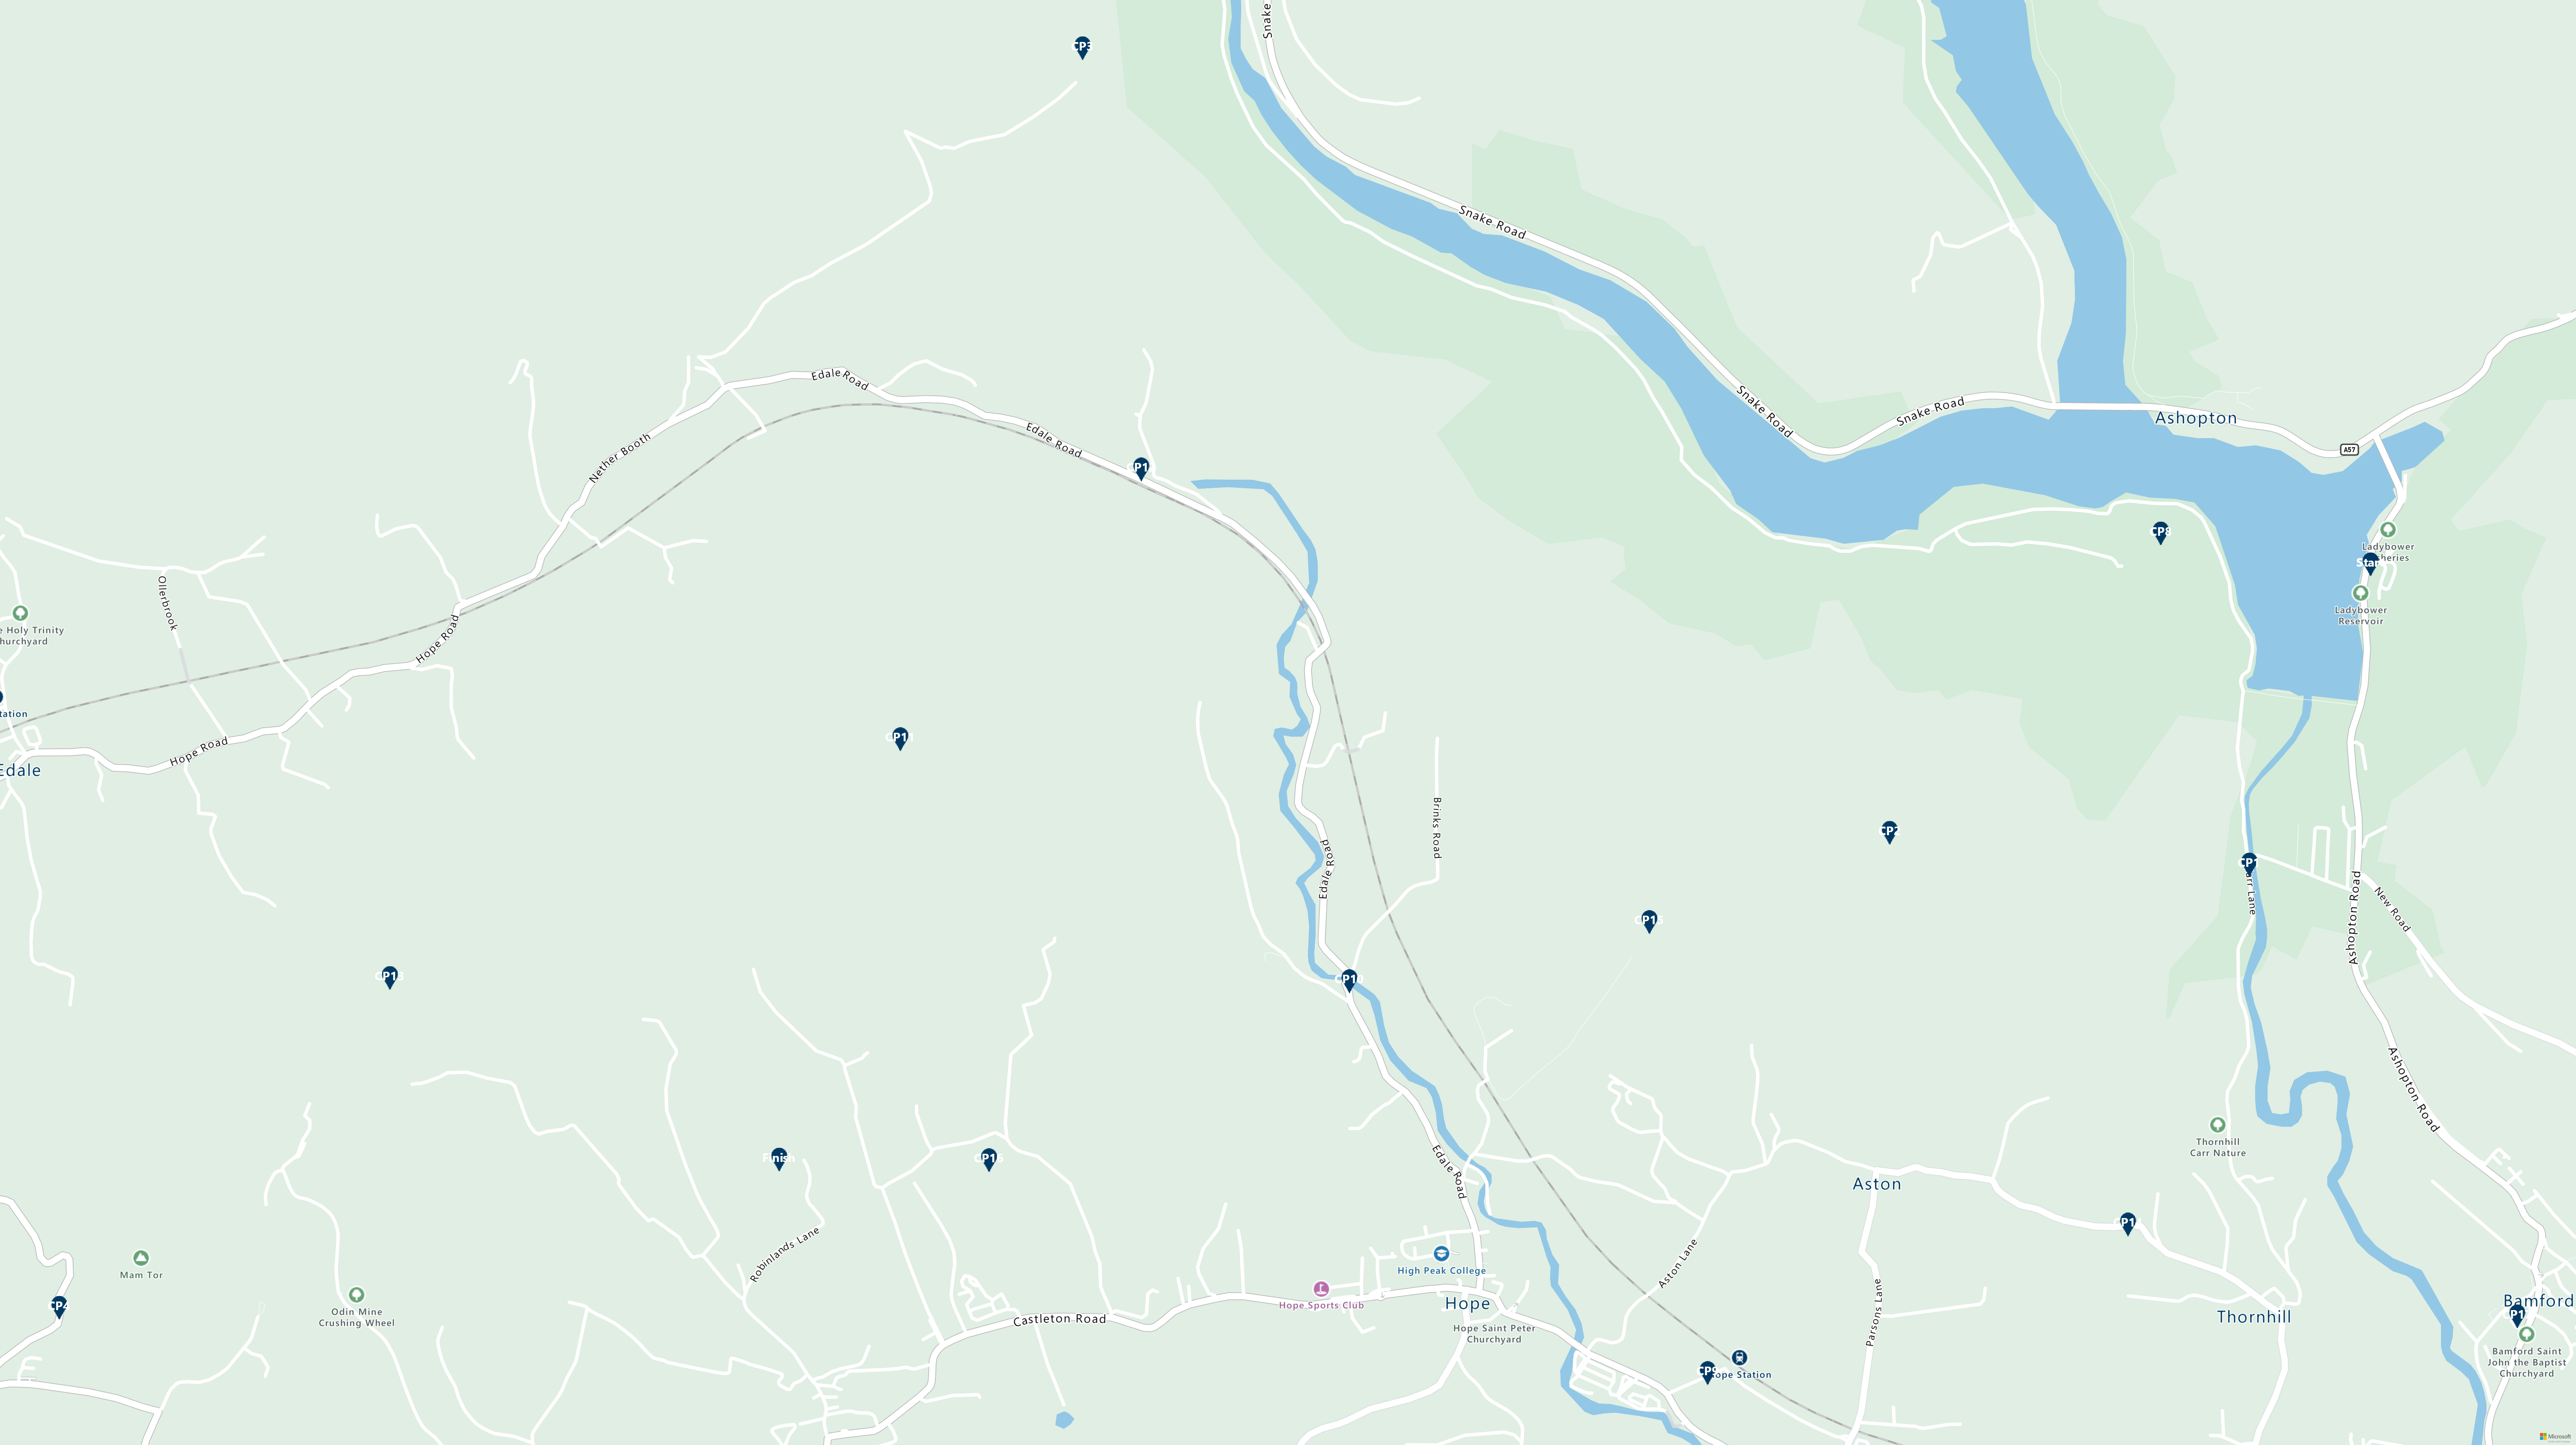

In [ ]:
if AzureMapsAPIKey != "":
  # Construct properly formatted markers
  markers = []
  for row in openings_df.collect():
      lat, lon, name = row["Latitude"], row["Longitude"], row["CP"]
      markers.append(f"'{name}'{lon} {lat}")  # Longitude first!

  pins = "default|ls15|sc1.5||" + "|".join(markers)

  # Construct the API URL
  params = {
      "subscription-key": AzureMapsAPIKey,
      "api-version": "1.0",
      "TilesetId": "microsoft.base", #microsoft.main.terra
      "zoom": 15,
  #   "Center": Center,
      "Bbox": LLBbox,
      "pins": pins
  }

  # Make API request
  response = requests.get("https://atlas.microsoft.com/map/static/png", params=params)

  # Check if request was successful
  if response.status_code == 200:
      display(Image(response.content))
  else:
      print("Error fetching map:", response.text)

else:
  print('No Azure Maps API Key, unable to query API')

### Google Maps plot Checkpoints

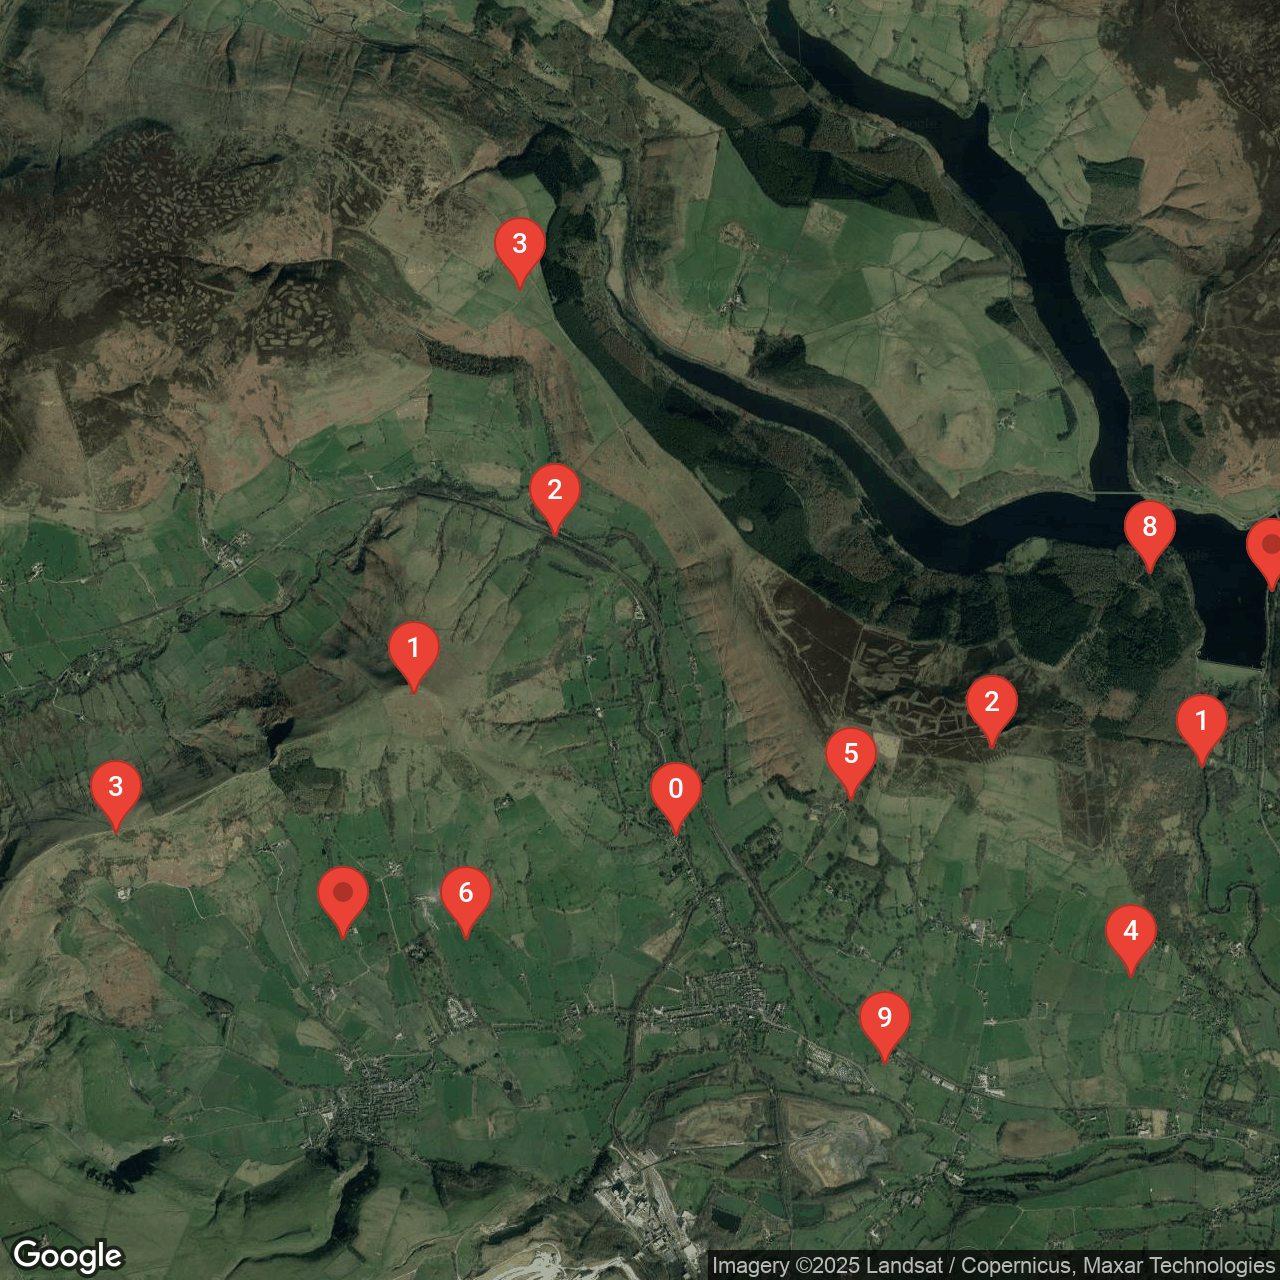

In [ ]:
if GoogleMapsAPIKey != "":
  marker_list = []
  for row in openings_df.collect():
    lat, lon, name = row["Latitude"], row["Longitude"], row["CP"]
    marker_list.append(f"color:red|label:{name[-1:]}|{lat},{lon}")
    # Google maps can only display 1 character on labels, great.

  params = {
    "size": "2000x2000",
    "scale": 2,
    "zoom": 13,
    "format": "png32",
    "maptype": "satellite", #terrain, hybrid, road, satellite
    "key": GoogleMapsAPIKey
  }

  # Properly format markers
  params["markers"] = "&markers=".join(marker_list)

  # Generate the request URL
  base_url = "https://maps.googleapis.com/maps/api/staticmap"
  request_url = f"{base_url}?size={params['size']}&scale={params['scale']}&zoom={params['zoom']}&format={params['format']}&maptype={params['maptype']}&markers={params['markers']}&key={params['key']}"

  response = requests.get(request_url)
  display(Image(response.content))

else:
  print('No Google Maps API Key, unable to query API')

## Ordnance Survey Map Plotting Calculations
### NGR to Tiles

In [ ]:
# Constants
# https://github.com/OrdnanceSurvey/tile-name-derivation is the font of knowledge

TILE_SIZE = 256  # Pixels per tile
ORIGIN_X = -238375.0  # False origin X
ORIGIN_Y = 1376256.0  # False origin Y

# Define scale per zoom level (meters per pixel)
ZOOM_RESOLUTIONS = {
    0: 896,
    1: 448,
    2: 224,
    3: 112,
    4: 56,
    5: 28,
    6: 14,
    7: 7,
    8: 3.5,
    9: 1.75,
    10: 0.875,
    11: 0.4375,
    12: 0.21875,
    13: 0.109375
}

def ngr_to_tile(easting, northing, zoom):
    """Convert BNG easting/northing to OS tile x, y at a given zoom level using false origin."""
    resolution = ZOOM_RESOLUTIONS.get(zoom, 896)  # Default to zoom 0 if not found
    # Calculate tile meters
    tile_meters = TILE_SIZE * (896 / (2 ** zoom))
    # Convert to tile coordinates
    tile_x = math.floor((easting - ORIGIN_X) / tile_meters)
    tile_y = math.floor((ORIGIN_Y - northing) / tile_meters)
    print(f"Zoom: {zoom}, Resolution: {resolution}m per pixel, Tile meters: {tile_meters}m")
    print(f"Easting: {easting}, Northing: {northing} -> Tile X: {tile_x}, Tile Y: {tile_y}")
    return tile_x, tile_y

# Convert bounding box to tile coordinates
x_min, y_min = ngr_to_tile(west, north, zoom_level)  # Top-left tile
x_max, y_max = ngr_to_tile(east, south, zoom_level)  # Bottom-right tile

# Generate all tile coordinates in range
tiles = [(zoom_level, x, y) for x in range(x_min, x_max + 1) for y in range(y_min, y_max + 1)]

# Print the tile coordinates
print(f"Total Tiles: {len(tiles)}")
for tile in tiles:
    print(tile)  # (zoom, x, y)

Zoom: 7, Resolution: 7m per pixel, Tile meters: 1792.0m
Easting: 412500, Northing: 387600 -> Tile X: 363, Tile Y: 551
Zoom: 7, Resolution: 7m per pixel, Tile meters: 1792.0m
Easting: 420700, Northing: 383200 -> Tile X: 367, Tile Y: 554
Total Tiles: 20
(7, 363, 551)
(7, 363, 552)
(7, 363, 553)
(7, 363, 554)
(7, 364, 551)
(7, 364, 552)
(7, 364, 553)
(7, 364, 554)
(7, 365, 551)
(7, 365, 552)
(7, 365, 553)
(7, 365, 554)
(7, 366, 551)
(7, 366, 552)
(7, 366, 553)
(7, 366, 554)
(7, 367, 551)
(7, 367, 552)
(7, 367, 553)
(7, 367, 554)


### Get Checkpoint Pixel coordinates

In [ ]:
def get_pixel_coords(easting, northing, zoom=zoom_level):
    tileMeters = TILE_SIZE * (896 / (2 ** zoom))  # Tile size in meters

    # Compute tile column and row
    tile_x = math.floor((easting - ORIGIN_X) / tileMeters)
    tile_y = math.floor((ORIGIN_Y - northing) / tileMeters)

    # Compute tile top-left corner
    tile_top_left_easting = ORIGIN_X + (tile_x * tileMeters)
    tile_top_left_northing = ORIGIN_Y - (tile_y * tileMeters)

    # Compute pixel coordinates within the tile
    pixel_x = (easting - tile_top_left_easting) / (tileMeters / 256)
    pixel_y = (tile_top_left_northing - northing) / (tileMeters / 256)

    return f"{pixel_x:.2f}, {pixel_y:.2f}"


### Add tilename and pixel coordinates to Openings_DF

In [ ]:
# Define UDF to format the tilename
def get_tilename(easting, northing, zoom=zoom_level):
    tile_x, tile_y = ngr_to_tile(easting, northing, zoom)
    return f"{zoom}/{tile_x}/{tile_y}"

# Register UDF
tile_name_udf = udf(get_tilename, StringType())
pixel_coords_udf = udf(get_pixel_coords, StringType())

openings_df = openings_df.withColumn("tilename", tile_name_udf(openings_df["NGR_Easting"], openings_df["NGR_Northing"]))
openings_df = openings_df.withColumn("pixel_coords", pixel_coords_udf(openings_df["NGR_Easting"], openings_df["NGR_Northing"]))

# Show result
display(openings_df)

DataFrame[CP: string, BNG: string, 1000: int, 1030: int, 1100: int, 1130: int, 1200: int, 1230: int, 1300: int, 1330: int, 1400: int, 1430: int, 1500: int, 1530: int, 1600: int, 1630: int, 1700
: double, NGR_Easting: int, NGR_Northing: int, Latitude: float, Longitude: float, tilename: string, pixel_coords: string]

###Fetch tiles and plot checkpoints

In [ ]:
if OrdnanceSurveyAPIKey != "":

  # Font settings (adjust as needed)
  try:
      font = ImageFont.truetype("arial.ttf", (zoom_level*2))  # Try loading Arial
  except IOError:
      font = ImageFont.load_default()  # Fallback if Arial is not available

  # Marker settings
  marker_radius = zoom_level  # Radius of the checkpoint circle
  marker_color = (255, 0, 0)  # Red color for marker
  text_color = (0, 0, 0)  # Black text for labels

  # Initialize the canvas
  canvas_width = (x_max - x_min + 1) * TILE_SIZE
  canvas_height = (y_max - y_min + 1) * TILE_SIZE
  canvas = PILImage.new('RGB', (canvas_width, canvas_height), (255, 255, 255))

  # Store processed tiles before stitching
  tile_images = {}

  # Loop through all tiles and download them
  for zoom, x, y in tiles:
      tile_url = f"https://api.os.uk/maps/raster/v1/zxy/{MapStyle}/{zoom}/{x}/{y}.png?key={OrdnanceSurveyAPIKey}"
      response = requests.get(tile_url)

      if response.status_code == 200:
          tile_img = PILImage.open(BytesIO(response.content))
          draw = ImageDraw.Draw(tile_img)

          # Find checkpoints that belong to this tile
          checkpoints_in_tile = openings_df.filter(
              (openings_df["tilename"] == f"{zoom}/{x}/{y}")
          ).collect()

          for checkpoint in checkpoints_in_tile:
              pixel_x, pixel_y = map(float, checkpoint["pixel_coords"].split(", "))
              name = checkpoint["CP"]  # Assuming column exists

              # Draw marker
              draw.ellipse(
                  (pixel_x - marker_radius, pixel_y - marker_radius,
                  pixel_x + marker_radius, pixel_y + marker_radius),
                  fill=marker_color
              )

              # Add text label
              draw.text((pixel_x + 8, pixel_y - 8), name, fill=text_color, font=font)

          # Store the modified tile
          tile_images[(x, y)] = tile_img

          print(f"Downloaded and processed tile: {tile_url}")
      else:
          print(f"Failed to download tile: {tile_url} - Status Code {response.status_code}")

  # Stitch tiles onto the canvas
  for (x, y), tile_img in tile_images.items():
      tile_x = (x - x_min) * TILE_SIZE
      tile_y = (y - y_min) * TILE_SIZE
      canvas.paste(tile_img, (tile_x, tile_y))
else:
  print('No Ordnance Survey API Key, unable to query API')

### Store Canvas in memory

In [ ]:
# 🔹 Save image to an in-memory buffer
buf = BytesIO()
canvas.save(buf, format="PNG")  # Save as PNG in memory
buf.seek(0)  # Move to start of buffer

# 🔹 Convert buffer to Base64
encoded_content = base64.b64encode(buf.read()).decode("utf-8")

filename = F"{Competition_Year}_OrdnanceSurvey_{MapStyle}_{zoom_level}_{datetime.today().date()}.png"

### Save canvas back to filestore

In [ ]:
if DovetrekRepoPAT != "":

  # 🔹 GitHub API URL
  url = f"https://api.github.com/repos/liamj-f/Dovetrek/contents/Maps/{filename}"

  # Get the latest SHA (if the file exists)
  response = requests.get(url, headers={"Authorization": f"token {DovetrekRepoPAT}"})
  sha = response.json().get("sha") if response.status_code == 200 else None

  # 🔹 Upload file to GitHub
  payload = {
      "message": "Auto-upload {filename} from memory",
      "content": encoded_content,
      "branch": "FileStore"
  }
  if sha:
      payload["sha"] = sha  # Required if updating an existing file

  response = requests.put(url, headers={"Authorization": f"token {DovetrekRepoPAT}"}, json=payload)

  if response.status_code in [200, 201]:
      print(f"✅ {filepath} uploaded successfully to Dovetrek/Maps (Filestore branch)!")
  else:
      print(f"❌ Error: {response.status_code} - {response.text}")

else:
  print("No Dovetrek Repo Access token provided, unable to save file back to filestore")